In [33]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation

In [2]:
data_path = "../../../data/predictive_maintenance.csv"

In [24]:
df = pd.read_csv(data_path)

In [28]:
# Split for features (X) und labels (y)
X = df.drop(columns=["Product ID", "Type", "Target", "Failure Type"])  # select Features 
y = df["Failure Type"]

In [29]:
# Split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and test

In [30]:
# Set the MLflow experiment
mlflow.set_experiment("logistic_regression_gs")

mlflow.sklearn.autolog()

# Define the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)

# Define the parameters for GridSearchCV
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10, 100]
}

# Define the pipeline
pipeline = Pipeline(steps=[('model', model)])

# Results dictionary
results = {}

# Accuracy as scoring metric
scorer = make_scorer(accuracy_score)

with mlflow.start_run():
    print("Training Logistic Regression Model...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring=scorer)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Logistic Regression Accuracy:", accuracy)
    mlflow.log_metric('accuracy', accuracy)
    
    mlflow.end_run()


2024/05/28 16:41:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/05/28 16:41:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these colum

Training Logistic Regression Model...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024/05/28 16:42:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declar

Logistic Regression Accuracy: 0.975


# Evaluation

In [31]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

## Classification report

In [34]:
print("Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.00      0.00      0.00        15
              No Failure       0.98      1.00      0.99      1935
      Overstrain Failure       0.67      0.15      0.25        13
           Power Failure       0.88      0.75      0.81        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.97      2000
               macro avg       0.42      0.32      0.34      2000
            weighted avg       0.96      0.97      0.97      2000



c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Confusion matrix

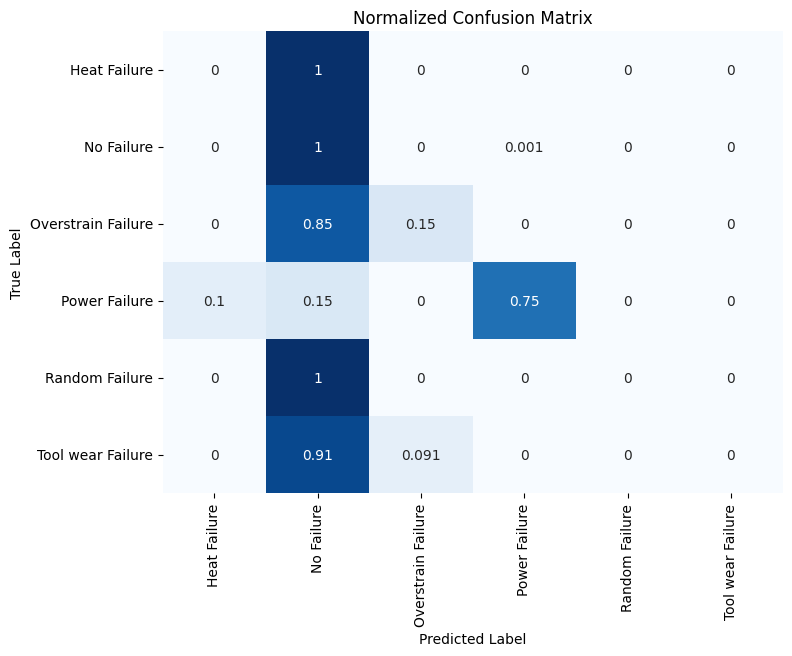

In [35]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()